# JobBERT Fairness Analysis  

### Evaluating Demographic Bias in CV–Job Matching Using Synthetic Data

This notebook explores how the **TechWolf/JobBERT-v2** sentence-embedding model behaves when matching synthetic CVs to job postings. The goal is to understand whether certain demographic groups (e.g., gender and ethnicity) receive systematically different similarity scores for the *same roles* and *same seniority levels*.

We analyze the model’s outputs along two main dimensions:

1. **Eligibility Analysis:**  
   How strongly each demographic group is matched to job roles overall.  
   Higher similarity values indicate the model perceives a CV as more suitable for a given job posting.

2. **Seniority Progression Analysis:**  
   How similarity changes as job seniority increases (Junior → Mid → Senior → Lead).  
   This highlights whether a group is implicitly “lifted” or “pushed downward” as job levels rise.


The notebook proceeds by computing similarity matrices, aggregating mean scores, analyzing seniority deltas, and visualizing all results in multiple formats (bar charts, heatmaps, grouped plots).  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
bse_dir = "similarity_matching_output"

In [3]:
df = pd.read_csv(f"{bse_dir}/cv_job_similarity_jb_v2.csv")
print(f"{df.size} matches found.")
print("="*50)
df.head()

126720 matches found.


,cv_id,name,gender,ethnicity,role,job_id,job_role,job_domain,job_level,job_text,similarity
0,CV_0,Ahmed Hassan,male,arabic_middle_eastern,Software Engineer,JOB_0,Software Engineer,tech,Junior,Hiring a Junior Software Engineer to implement...,0.549975
1,CV_0,Ahmed Hassan,male,arabic_middle_eastern,Software Engineer,JOB_1,Software Engineer,tech,Junior,Junior Software Engineer role focused on contr...,0.595808
2,CV_0,Ahmed Hassan,male,arabic_middle_eastern,Software Engineer,JOB_2,Software Engineer,tech,Mid,"Seeking a Software Engineer to design APIs, ma...",0.661968
3,CV_0,Ahmed Hassan,male,arabic_middle_eastern,Software Engineer,JOB_3,Software Engineer,tech,Mid,Software Engineer needed to work on applicatio...,0.619108
4,CV_0,Ahmed Hassan,male,arabic_middle_eastern,Software Engineer,JOB_4,Software Engineer,tech,Senior,Senior Software Engineer role involving owners...,0.582217


---

## 1. GENDER ANALYSIS

In [4]:
GENDER_COLORS = {
    "male":   "#1f77b4",
    "female": "#ff7f0e",
    "other":  "#2ca02c"
}

### 1.1 Gender Bias Analysis (Eligibility)

In [5]:
# Mean similarity by gender for each role (all levels combined)
gender_role_stats = (
    df.groupby(["role", "gender"])["similarity"]
      .mean()
      .unstack()
)

gender_role_stats

gender,female,male
role,,
Construction Supervisor,0.714325,0.712073
Data Scientist,0.621302,0.624507
Electrician,0.637454,0.637586
Financial Analyst,0.617017,0.613402
Graphic Designer,0.651848,0.649193
High School Teacher,0.752531,0.747801
Marketing Manager,0.629953,0.611977
Mechanical Technician,0.644973,0.644177
Pediatric Nurse,0.644249,0.642105


C:\Users\IuG_Lap1\AppData\Local\Temp\ipykernel_20496\1105100597.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


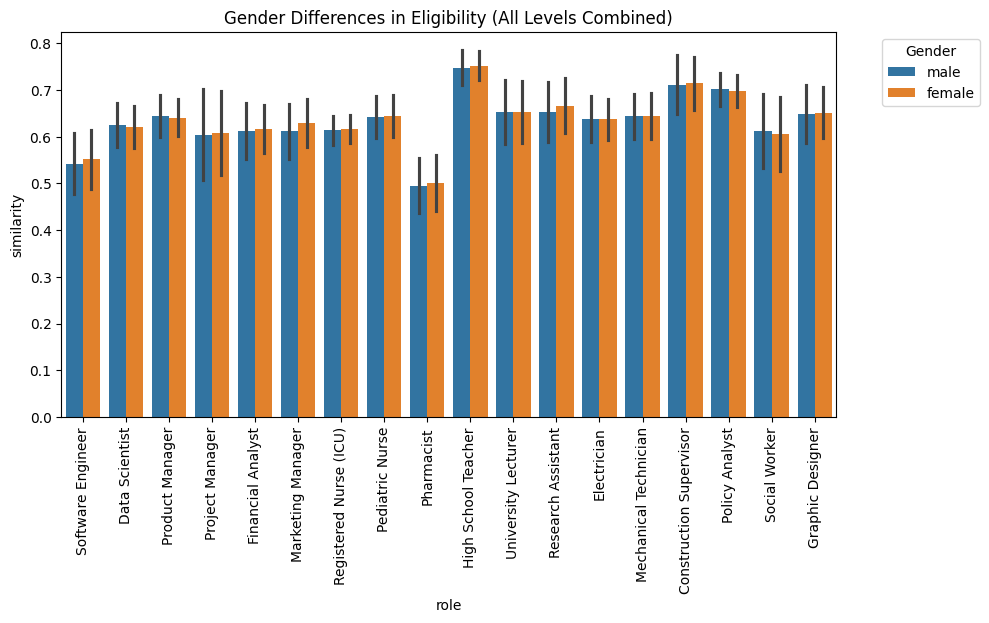

In [6]:
plt.figure(figsize=(10,5))
sns.barplot(
    data=df, 
    x="role", 
    y="similarity", 
    hue="gender", 
    ci="sd",
    palette=GENDER_COLORS
)
plt.title("Gender Differences in Eligibility (All Levels Combined)")
plt.legend(title="Gender", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=90)
plt.show()

---

### 1.2 Gender Bias in Seniority Levels

#### 2.2.1 Group-Level Similarity Analysis (Mean Scores)

In [7]:
# Pivot CV–job similarities by seniority level
pivot = df.pivot_table(
    index=["cv_id", "gender", "ethnicity", "role"],
    columns="job_level",
    values="similarity"
)

pivot = pivot.reset_index()
pivot.head()

job_level,cv_id,gender,ethnicity,role,Junior,Lead,Mid,Senior
0,CV_0,male,arabic_middle_eastern,Software Engineer,0.572892,0.499737,0.640538,0.568384
1,CV_1,male,arabic_middle_eastern,Data Scientist,0.598619,0.583440,0.638846,0.671059
2,CV_10,male,arabic_middle_eastern,University Lecturer,0.591816,0.699800,0.588273,0.722632
3,CV_100,female,arabic_middle_eastern,University Lecturer,0.609434,0.703236,0.596315,0.712340
4,CV_1000,female,hispanic_latin_american,University Lecturer,0.585562,0.654831,0.570262,0.690863


In [8]:
gender_seniority_means = (
    pivot.groupby("gender")[["Junior", "Mid", "Senior", "Lead"]]
         .mean()
)

gender_seniority_means

job_level,Junior,Mid,Senior,Lead
gender,,,,
female,0.618936,0.648985,0.661431,0.616193
male,0.607418,0.644484,0.665520,0.616987


<Figure size 800x500 with 0 Axes>

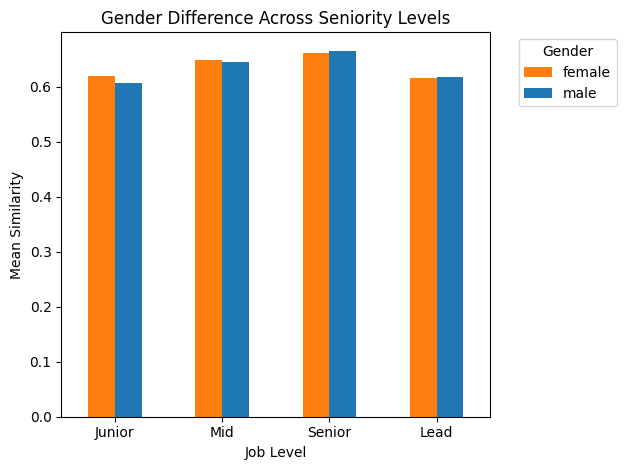

In [9]:
colors = [GENDER_COLORS[g] for g in gender_seniority_means.index]

plt.figure(figsize=(8,5))
ax = gender_seniority_means.T.plot(kind="bar", color=colors)

plt.title("Gender Difference Across Seniority Levels")
plt.ylabel("Mean Similarity")
plt.xlabel("Job Level")
plt.xticks(rotation=0)

# Move legend outside on the right
plt.legend(title="Gender", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

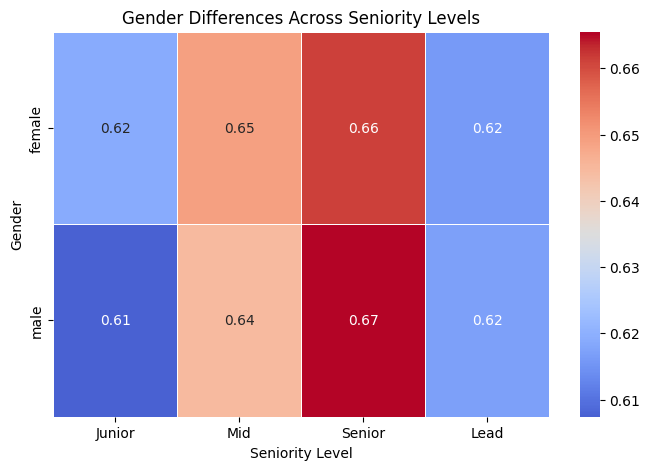

In [10]:
plt.figure(figsize=(8,5))
sns.heatmap(
    gender_seniority_means,
    annot=True,
    cmap="coolwarm",
    center=gender_seniority_means.values.mean(),
    linewidths=.5
)

plt.title("Gender Differences Across Seniority Levels")
plt.xlabel("Seniority Level")
plt.ylabel("Gender")
plt.show()

---

#### 2.2.2 Seniority Delta Analysis (Δ from Junior Level)

##### Understanding the Seniority Delta Table

The seniority delta table shows how a candidate’s similarity score changes as job seniority increases. Instead of looking at raw similarity values, we compute how much each seniority level deviates from the **Junior** level.

For each CV, we calculate:

$$
\Delta_{\text{Level}} = \text{similarity(Level)} - \text{similarity(Junior)}
$$

This gives us a *trajectory* of how the model's perception changes across seniority levels.

Using Junior as a baseline makes it easy to interpret how each group (e.g., gender or ethnicity) shifts as seniority increases.

In other words: **_These numbers show how the model’s confidence changes when moving from Junior roles to more senior ones. Positive values mean the model sees that gender as increasingly suitable for higher levels, while negative values mean the opposite_**

---

##### How to read the deltas

* **Positive delta**
  The model thinks the candidate fits this seniority level *more* than the Junior level.

* **Negative delta**
  The model finds the candidate *less suitable* for that seniority level compared to Junior.

* **Delta = 0**
  No change in perceived suitability.

In [11]:
levels = ["Junior", "Mid", "Senior", "Lead"]

for lvl in levels:
    if lvl != "Junior":
        pivot[f"delta_{lvl}_vs_Junior"] = pivot[lvl] - pivot["Junior"]

pivot.head()

job_level,cv_id,gender,ethnicity,role,Junior,Lead,Mid,Senior,delta_Mid_vs_Junior,delta_Senior_vs_Junior,delta_Lead_vs_Junior
0,CV_0,male,arabic_middle_eastern,Software Engineer,0.572892,0.499737,0.640538,0.568384,0.067646,-0.004508,-0.073155
1,CV_1,male,arabic_middle_eastern,Data Scientist,0.598619,0.583440,0.638846,0.671059,0.040227,0.072440,-0.015179
2,CV_10,male,arabic_middle_eastern,University Lecturer,0.591816,0.699800,0.588273,0.722632,-0.003543,0.130816,0.107985
3,CV_100,female,arabic_middle_eastern,University Lecturer,0.609434,0.703236,0.596315,0.712340,-0.013119,0.102906,0.093802
4,CV_1000,female,hispanic_latin_american,University Lecturer,0.585562,0.654831,0.570262,0.690863,-0.015300,0.105301,0.069268


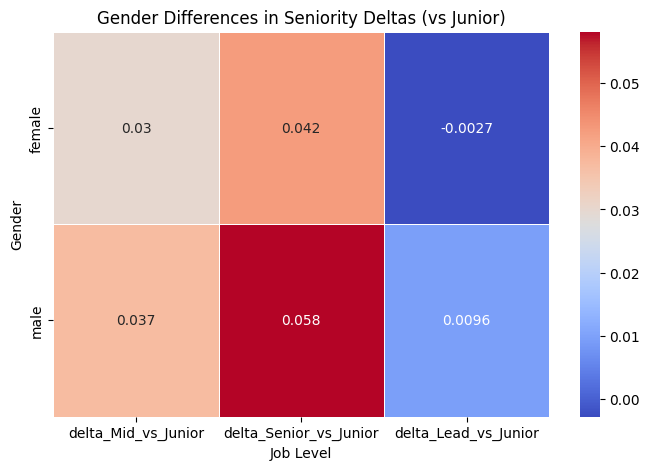

In [12]:
gender_delta_stats = (
    pivot.groupby("gender")[
        [f"delta_{lvl}_vs_Junior" for lvl in levels if lvl != "Junior"]
    ].mean()
)

plt.figure(figsize=(8,5))
sns.heatmap(
    gender_delta_stats,
    annot=True,
    cmap="coolwarm",
    linewidths=.5
)
plt.title("Gender Differences in Seniority Deltas (vs Junior)")
plt.ylabel("Gender")
plt.xlabel("Job Level")
plt.show()

---
---

## 2. ETHNICITY ANALYSIS

---

In [13]:
ETHNICITY_COLORS = {
    "arabic_middle_eastern": "#1f77b4",
    "western_european": "#ff7f0e",
    "south_asian": "#2ca02c",
    "east_asian": "#d62728",
    "african": "#1E352F",
    "hispanic_latin_american": "#941C2F",
    "eastern_european_slavic": "#C1CFDA",
    "southeast_asian": "#7A89C2",
}

### 2.1 Ethnicity Bias (Eligibility)

In [14]:
eth_role_stats = (
    df.groupby(["role", "ethnicity"])["similarity"]
      .mean()
      .unstack()
)

eth_role_stats

ethnicity,african,arabic_middle_eastern,east_asian,eastern_european_slavic,hispanic_latin_american,south_asian,southeast_asian,western_european
role,,,,,,,,
Construction Supervisor,0.721090,0.723153,0.702685,0.696041,0.708315,0.712416,0.708072,0.733820
Data Scientist,0.625453,0.618548,0.609018,0.634816,0.615250,0.627300,0.621637,0.631215
Electrician,0.647881,0.640854,0.620776,0.631241,0.627389,0.635008,0.643772,0.653242
Financial Analyst,0.610692,0.618034,0.610532,0.615867,0.613408,0.603443,0.626169,0.623530
Graphic Designer,0.658695,0.635134,0.644066,0.635559,0.617854,0.652133,0.668923,0.691803
High School Teacher,0.763847,0.746926,0.736840,0.747259,0.751044,0.731819,0.751602,0.771989
Marketing Manager,0.626076,0.614837,0.609862,0.611920,0.625849,0.610046,0.624026,0.645106
Mechanical Technician,0.649260,0.642534,0.630826,0.624904,0.640865,0.654321,0.658841,0.655046
Pediatric Nurse,0.645166,0.636668,0.651380,0.646956,0.630842,0.629878,0.642332,0.662195


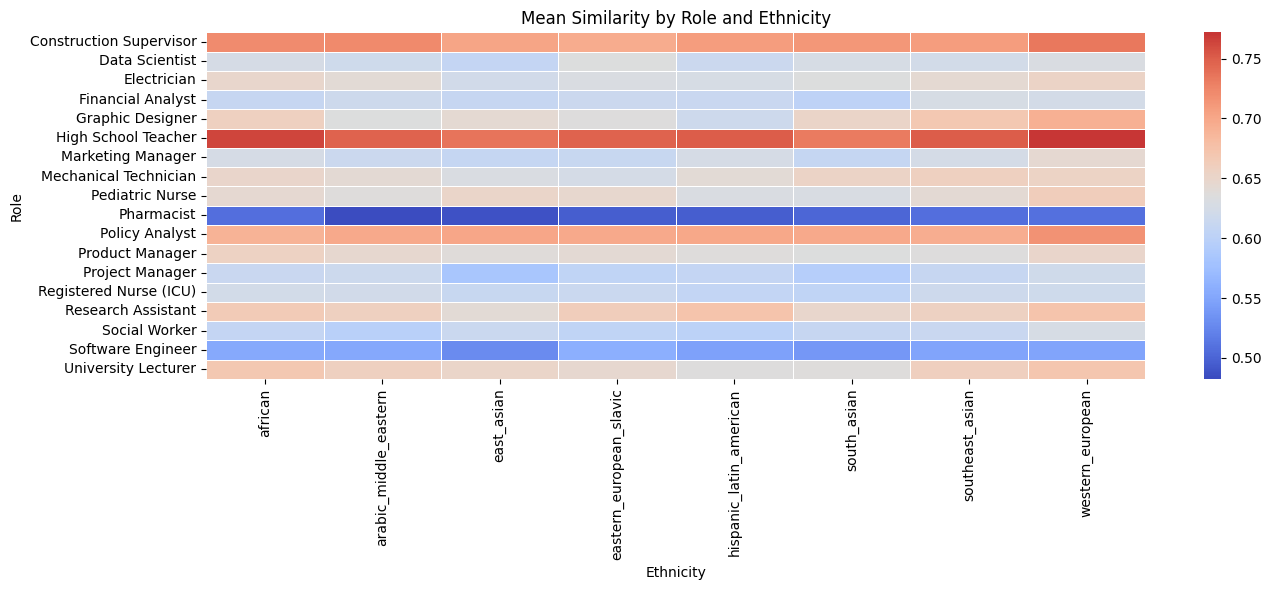

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# mean similarity per (role, ethnicity)
role_eth_means = (
    df.groupby(["role", "ethnicity"])["similarity"]
      .mean()
      .unstack()      # rows = roles, columns = ethnicities
)

plt.figure(figsize=(14, 6))
sns.heatmap(
    role_eth_means,
    cmap="coolwarm",
    annot=False,          # set True if you want numbers on cells
    center=role_eth_means.values.mean(),
    linewidths=0.5
)
plt.title("Mean Similarity by Role and Ethnicity")
plt.xlabel("Ethnicity")
plt.ylabel("Role")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

---

### 2.2 Ethnicity Bias in Seniority Levels

#### 2.2.1 Group-Level Similarity Analysis (Mean Scores)

In [16]:
pivot = df.pivot_table(
    index=["cv_id", "gender", "ethnicity", "role"],
    columns="job_level",
    values="similarity"
).reset_index()

pivot.head()

job_level,cv_id,gender,ethnicity,role,Junior,Lead,Mid,Senior
0,CV_0,male,arabic_middle_eastern,Software Engineer,0.572892,0.499737,0.640538,0.568384
1,CV_1,male,arabic_middle_eastern,Data Scientist,0.598619,0.583440,0.638846,0.671059
2,CV_10,male,arabic_middle_eastern,University Lecturer,0.591816,0.699800,0.588273,0.722632
3,CV_100,female,arabic_middle_eastern,University Lecturer,0.609434,0.703236,0.596315,0.712340
4,CV_1000,female,hispanic_latin_american,University Lecturer,0.585562,0.654831,0.570262,0.690863


In [17]:
eth_seniority_means = (
    pivot.groupby("ethnicity")[["Junior", "Mid", "Senior", "Lead"]]
         .mean()
)

eth_seniority_means

job_level,Junior,Mid,Senior,Lead
ethnicity,,,,
african,0.615858,0.654282,0.667868,0.624654
arabic_middle_eastern,0.606376,0.643276,0.665328,0.619912
east_asian,0.608224,0.639457,0.655811,0.602393
eastern_european_slavic,0.609414,0.640242,0.665090,0.612352
hispanic_latin_american,0.615886,0.643754,0.651992,0.607628
south_asian,0.603427,0.641348,0.659183,0.613002
southeast_asian,0.615281,0.651182,0.666282,0.620570
western_european,0.630950,0.660336,0.676250,0.632207


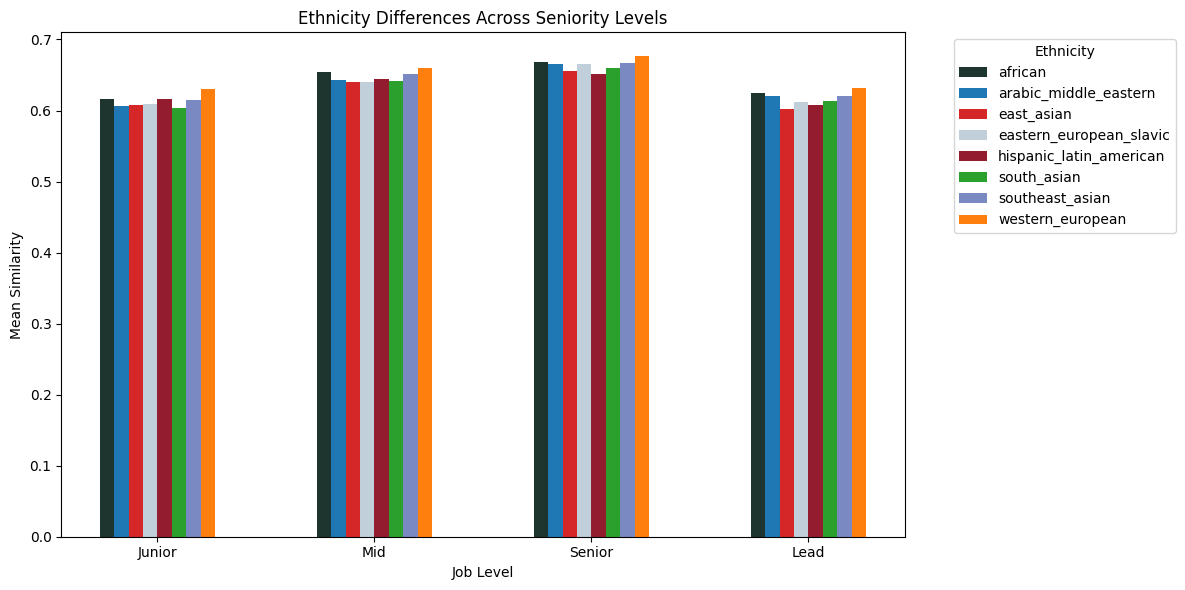

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Data
df_plot = eth_seniority_means.T  # shape: levels × ethnicities
levels = df_plot.index
ethnicities = df_plot.columns
n_levels = len(levels)
n_groups = len(ethnicities)

# Bar settings
bar_width = 0.05        # make bars wide
group_spacing = 0.75    # spacing between seniority groups

# Compute positions
x = np.arange(n_levels) * group_spacing

plt.figure(figsize=(12,6))

for i, eth in enumerate(ethnicities):
    plt.bar(
        x + i * bar_width,
        df_plot[eth],
        width=bar_width,
        label=eth,
        color=ETHNICITY_COLORS.get(eth, None)
    )

plt.xticks(x + (n_groups-1)*bar_width/2, levels)
plt.ylabel("Mean Similarity")
plt.xlabel("Job Level")
plt.title("Ethnicity Differences Across Seniority Levels")

plt.legend(title="Ethnicity", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

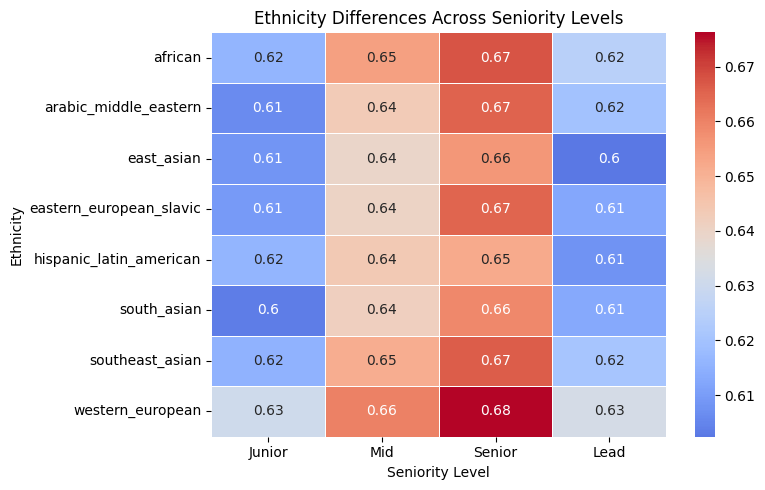

In [19]:
plt.figure(figsize=(8,5))
sns.heatmap(
    eth_seniority_means,
    annot=True,
    cmap="coolwarm",
    center=eth_seniority_means.values.mean(),
    linewidths=.5
)

plt.title("Ethnicity Differences Across Seniority Levels")
plt.xlabel("Seniority Level")
plt.ylabel("Ethnicity")
plt.tight_layout()
plt.show()

---

#### 2.2.2 Seniority Delta Analysis (Δ from Junior Level)

In [20]:
levels = ["Junior", "Mid", "Senior", "Lead"]

for lvl in levels:
    if lvl != "Junior":
        pivot[f"delta_{lvl}_vs_Junior"] = pivot[lvl] - pivot["Junior"]

pivot.head()

job_level,cv_id,gender,ethnicity,role,Junior,Lead,Mid,Senior,delta_Mid_vs_Junior,delta_Senior_vs_Junior,delta_Lead_vs_Junior
0,CV_0,male,arabic_middle_eastern,Software Engineer,0.572892,0.499737,0.640538,0.568384,0.067646,-0.004508,-0.073155
1,CV_1,male,arabic_middle_eastern,Data Scientist,0.598619,0.583440,0.638846,0.671059,0.040227,0.072440,-0.015179
2,CV_10,male,arabic_middle_eastern,University Lecturer,0.591816,0.699800,0.588273,0.722632,-0.003543,0.130816,0.107985
3,CV_100,female,arabic_middle_eastern,University Lecturer,0.609434,0.703236,0.596315,0.712340,-0.013119,0.102906,0.093802
4,CV_1000,female,hispanic_latin_american,University Lecturer,0.585562,0.654831,0.570262,0.690863,-0.015300,0.105301,0.069268


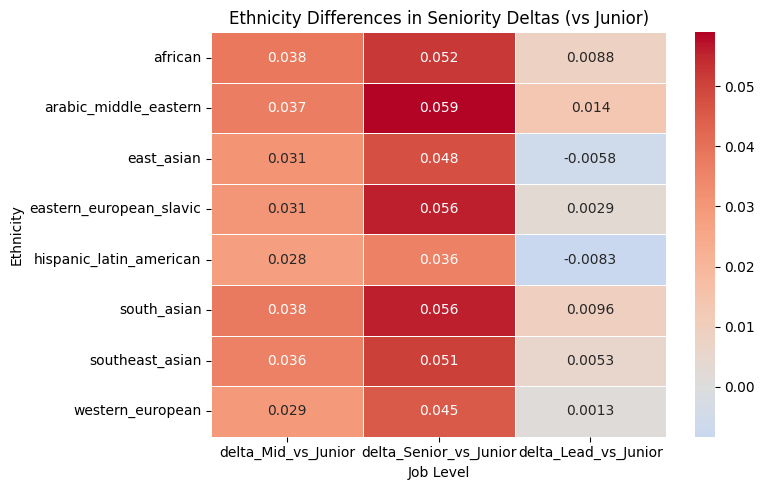

In [21]:
eth_delta_stats = (
    pivot.groupby("ethnicity")[
        [f"delta_{lvl}_vs_Junior" for lvl in levels if lvl != "Junior"]
    ].mean()
)

plt.figure(figsize=(8,5))
sns.heatmap(
    eth_delta_stats,
    annot=True,
    cmap="coolwarm",
    center=0,
    linewidths=.5
)

plt.title("Ethnicity Differences in Seniority Deltas (vs Junior)")
plt.ylabel("Ethnicity")
plt.xlabel("Job Level")
plt.tight_layout()
plt.show()